# Import Libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

2025-08-26 21:02:43.867918: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756242163.894063     306 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756242163.901857     306 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Load Datasets

## mnist dataset

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Concate train and test in one variable
x1 = np.concatenate([x_train, x_test])
y1 = np.concatenate([y_train, y_test])

x1 = np.expand_dims(x1, -1) 

## Handwritten digits dataset

In [3]:
path="/kaggle/input/handwritten-digits-0-9"
data2 = tf.keras.utils.image_dataset_from_directory(
    path,
    image_size=(28, 28),
    color_mode="grayscale",
    label_mode="int"
)

x2, y2 = [], []
for images, labels in data2:
    x2.append(images.numpy())
    y2.append(labels.numpy())

x2 = np.concatenate(x2, axis=0)
y2 = np.concatenate(y2, axis=0)

Found 21555 files belonging to 10 classes.


2025-08-26 21:02:51.359973: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Concate the two datasets in one

In [4]:
x = np.concatenate([x1, x2])
y = np.concatenate([y1, y2])

# Show random samples of dataset

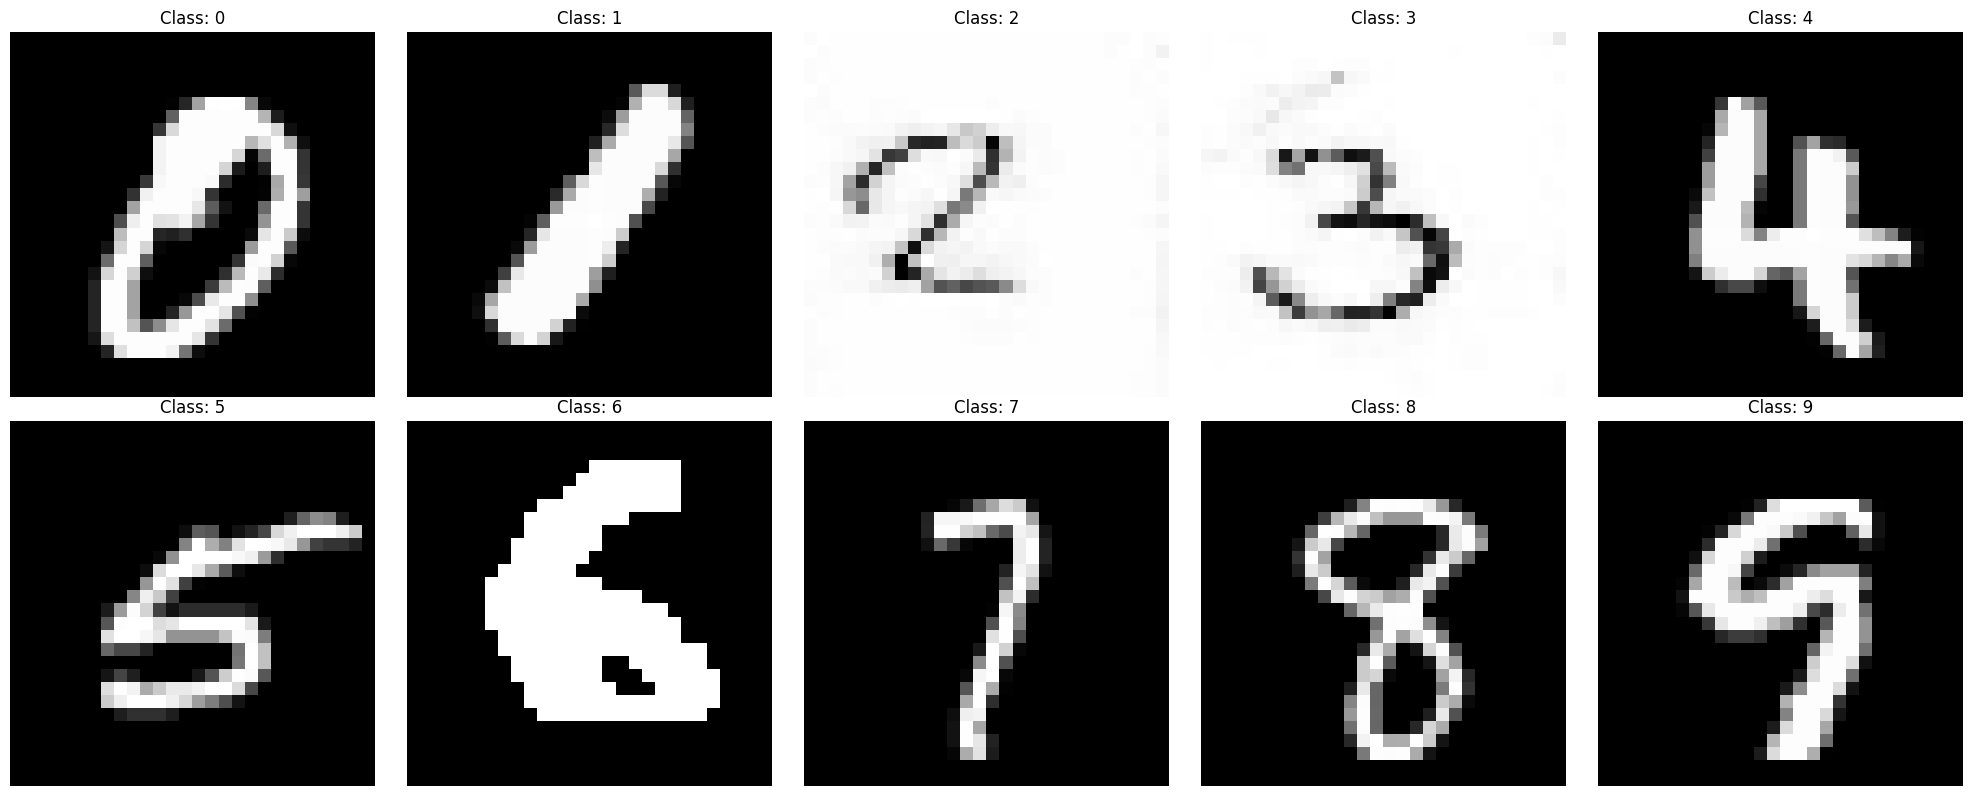

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.ravel()

classes = np.unique(y)

for i, cls in enumerate(classes[:10]):
    idx = np.random.choice(np.where(y == cls)[0])
    img = x[idx]

    if img.ndim == 3 and img.shape[-1] == 1:
        img = img.squeeze(-1)

    axes[i].imshow(img, cmap="gray")
    axes[i].set_title(f"Class: {cls}")
    axes[i].axis("off")

plt.tight_layout()
plt.show()

# Data splitting

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2,random_state=42,stratify=y)

# Data augmentation

In [7]:
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1
)

# Customized Model

In [8]:
model = models.Sequential([
    layers.Input(shape=(28,28,1)),
    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(10, activation='softmax')
])

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

es = EarlyStopping(patience=3, restore_best_weights=True)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,034 (879.04 KB)

 Trainable params: 225,034 (879.04 KB)

 Non-trainable params: 0 (0.00 B)

# Fitting the model

In [9]:
# Normalization
x_train = x_train.astype("float32") / 255.0
x_test  = x_test.astype("float32") / 255.0

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=128),
    validation_data=(x_test, y_test),
    epochs=15,
    callbacks=[es],
    verbose=1
)

Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


573/573 ━━━━━━━━━━━━━━━━━━━━ 40s 66ms/step - accuracy: 0.6488 - loss: 1.0497 - val_accuracy: 0.9442 - val_loss: 0.1976
Epoch 2/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 37s 65ms/step - accuracy: 0.8928 - loss: 0.3474 - val_accuracy: 0.9563 - val_loss: 0.1428
Epoch 3/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 37s 65ms/step - accuracy: 0.9198 - loss: 0.2565 - val_accuracy: 0.9698 - val_loss: 0.0987
Epoch 4/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 37s 65ms/step - accuracy: 0.9365 - loss: 0.2061 - val_accuracy: 0.9761 - val_loss: 0.0814
Epoch 5/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 37s 65ms/step - accuracy: 0.9449 - loss: 0.1813 - val_accuracy: 0.9792 - val_loss: 0.0701
Epoch 6/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 37s 65ms/step - accuracy: 0.9519 - loss: 0.1557 - val_accuracy: 0.9813 - val_loss: 0.0626
Epoch 7/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 37s 65ms/step - accuracy: 0.9562 - loss: 0.1403 - val_accuracy: 0.9826 - val_loss: 0.0583
Epoch 8/15
573/573 ━━━━━━━━━━━━━━━━━━━━ 40s 69ms/step - accuracy: 0.9593 - loss: 0.1300 - val_accurac

# Plotting

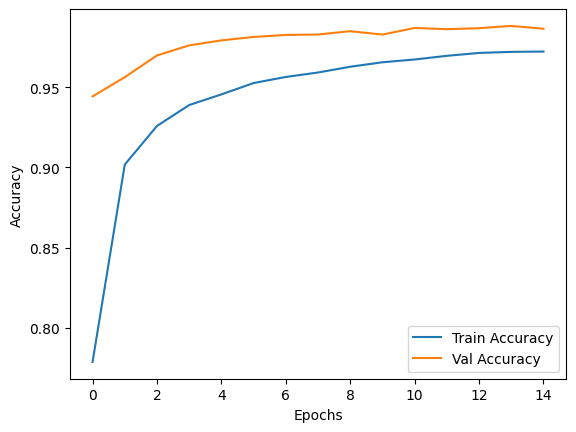

In [10]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Show samples of predicted classes

573/573 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


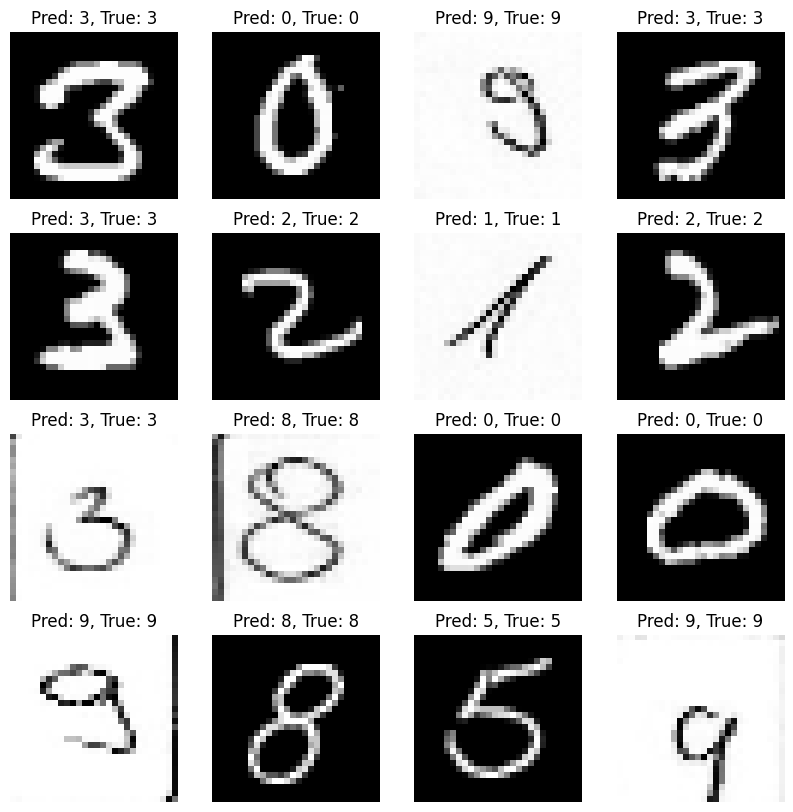

In [11]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)

plt.figure(figsize=(10,10))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.imshow(x_test[i].squeeze(), cmap="gray")
    plt.title(f"Pred: {y_pred[i]}, True: {y_test[i]}")
    plt.axis("off")
plt.show()

## Model prediction & evaluation

In [12]:
y_pred = model.predict(x_test).argmax(axis=1)
print(classification_report(y_test, y_pred))

573/573 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      1828
           1       1.00      0.99      0.99      2023
           2       0.99      0.99      0.99      1845
           3       0.99      0.99      0.99      1869
           4       0.99      0.99      0.99      1800
           5       0.98      0.99      0.99      1688
           6       0.99      0.99      0.99      1799
           7       0.99      0.99      0.99      1882
           8       0.98      0.98      0.98      1782
           9       0.99      0.98      0.98      1795

    accuracy                           0.99     18311
   macro avg       0.99      0.99      0.99     18311
weighted avg       0.99      0.99      0.99     18311



# Confusion matrix

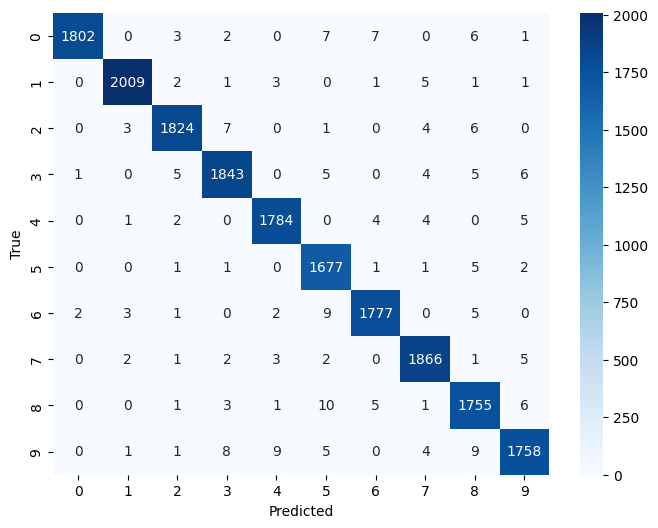

In [13]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Save model & Convert to TensorFlow Lite

In [14]:
model.save("digit_recognizer.h5")

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("digit_recognizer.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmpsk1n854t'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  137445038099344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137445150175312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137445150174160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137445038098384: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137445038098192: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137445150175504: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137445150176080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137445038099152: TensorSpec(shape=(), dtype=tf.resource, name=None)


W0000 00:00:1756242746.045307     306 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1756242746.045386     306 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
I0000 00:00:1756242746.052306     306 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
